In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")

# Features und Ziel
X = data.drop(columns=["price"])
y = data["price"]
for col in ["cityname", "state"]:
    X[col] = X[col].astype("category")


## Daten
Es werden states als auch cities als kategoriale Features mitgegeben --> XGBoost kann damit anscheinend umgehen

Zum Testen welche Features gebraucht werden

In [2]:
"""import pandas as pd
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")

# Features und Ziel
X = data[["square_feet", "state", "cityname", "bedrooms", "bathrooms"]]
y = data["price"]
"""

'import pandas as pd\nfrom sklearn.preprocessing import StandardScaler\n\ndata = pd.read_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv")\n\n# Features und Ziel\nX = data[["square_feet", "state", "cityname", "bedrooms", "bathrooms"]]\ny = data["price"]\n'

## 🚀 Hyperparameter des GradientBoostingRegressor

Der **Gradient Boosting Regressor (GBR)** ist eine **sequenzielle Ensemble-Methode**, die schwache Modelle (typischerweise Entscheidungsbäume) iterativ kombiniert. Die Parameter definieren das Suchgitter (`gbr_params`) für die Optimierung in der Nested Cross-Validation.

| Parameter | Beschreibung | Im Code definierte Werte |
| :--- | :--- | :--- |
| **`n_estimators`** | Die **Anzahl der Boosting-Stufen** (Anzahl der sequenziell hinzugefügten schwachen Lerner, d.h. Bäume). | `[5, 50]` |
| **`learning_rate`** | Die **Schrumpfungsrate** ($\eta$). Skaliert den Beitrag jedes Baumes. Ein kleinerer Wert erfordert mehr `n_estimators`, verbessert aber oft die Generalisierung. | `[0.1, 0.2]` |
| **`max_depth`** | Die **maximale Tiefe** jedes einzelnen Entscheidungsbaums (des *schwachen Lerners*). GBR verwendet meist flache Bäume (z.B. Tiefe 3-5). | `[3, 5, 7]` |
| **`min_samples_split`** | Die **minimale Anzahl von Datenpunkten** in einem internen Knoten, die für eine Teilung erforderlich ist. Dient zur Kontrolle der Baumkomplexität. | `[5, 10]` |

---

### 💡 Erläuterung der Boosting-Strategie



Gradient Boosting arbeitet, indem es sequentielle Bäume aufbaut, wobei jeder neue Baum versucht, die **Restfehler** (Residuen) des vorherigen Ensembles zu korrigieren.

1.  **`n_estimators`** und **`learning_rate`** steuern zusammen die **Gesamtstärke** des Modells und die Geschwindigkeit des Lernprozesses.
2.  **`max_depth`** und **`min_samples_split`** steuern die **Komplexität** jedes einzelnen, schwachen Entscheidungsbaums, der zur Korrektur der Residuen verwendet wird.

In [2]:
from Nested_CV_targetEncoding import NestedCVRegressorWithTargetEncoding
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    random_state=42,
    n_jobs=-1,
    enable_categorical=True
    # alle CPU-Kerne nutzen
)

# Hyperparameter-Grid
xgb_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7,None],
    "learning_rate": [0.05, 0.1, 0.2],
    #"subsample": [0.8, 1.0],
    #"colsample_bytree": [0.8, 1.0],
    #"gamma": [0, 1],  # Minimum Loss Reduction
    #"reg_alpha": [0, 0.1],  # L1 Regularisierung
    #"reg_lambda": [1, 5]    # L2 Regularisierung
}

xgb_cv = NestedCVRegressorWithTargetEncoding(xgb_model, xgb_params, encode_cols=[], scaler=None)

print("Starte XGBoost Nested CV...")
xgb_cv.run(X, y, output=True)

print("\n--- XGBoost Ergebnisse ---")
print("Mean R²:", xgb_cv.get_mean_r2())
print("Best params:", xgb_cv.get_best_params())


Starte XGBoost Nested CV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Outer Fold 1/5 | Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300} | Fit Time: 7.353s | Outer R²: 0.832 | MSE: 79617.810
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Outer Fold 2/5 | Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300} | Fit Time: 7.035s | Outer R²: 0.832 | MSE: 77813.146
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Outer Fold 3/5 | Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300} | Fit Time: 7.339s | Outer R²: 0.836 | MSE: 76258.167
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Outer Fold 4/5 | Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300} | Fit Time: 7.249s | Outer R²: 0.826 | MSE: 80576.796
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Ou

# Erkenntnisse
Ohne Scaler und ohne target ENcoding am besten

Vorteil: Kann direkt mit categorcals umgehen

In [3]:
number_outer_cv_splits = 5
model_evaluation = pd.DataFrame({"Fold": range(1, number_outer_cv_splits+1)})
model_evaluation['Modell'] = ['XGBOOST'] * number_outer_cv_splits
model_evaluation['R_2'] = xgb_cv.get_r2_scores()
model_evaluation['MSE'] = xgb_cv.get_mse_scores()
model_evaluation["runtime"] = xgb_cv.get_fit_times()
model_evaluation

,Fold,Modell,R_2,MSE,runtime
0,1,XGBOOST,0.831630,79617.809970,7.352541
1,2,XGBOOST,0.832216,77813.145797,7.035414
2,3,XGBOOST,0.836183,76258.166773,7.338948
3,4,XGBOOST,0.826376,80576.795775,7.249161
4,5,XGBOOST,0.835026,76612.194402,7.311806


In [4]:
model_evaluation.to_pickle('benchmarking/XGBOOST.pkl')

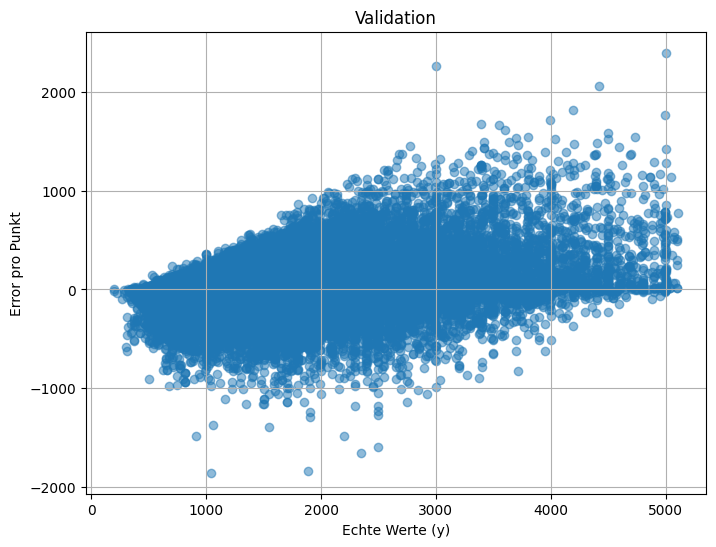

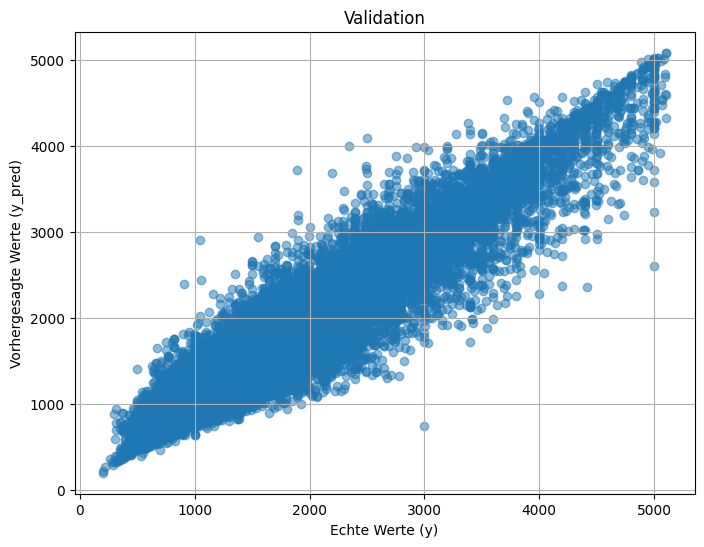

In [5]:
best_params = {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}
xgb_final_model = xgb.XGBRegressor(
    objective='reg:squarederror', learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'],
    random_state=42, n_jobs=-1, enable_categorical=True)
xgb_final_model.fit(X, y)
# Vorhersagen
y_pred = xgb_final_model.predict(X)

import matplotlib.pyplot as plt
# RMSE pro Punkt (Absolutfehler oder quadratischer Fehler)
rmse_per_point = (y - y_pred)  # = |y_i - y_pred_i|

# Plot
plt.figure(figsize=(8,6))
plt.scatter(y, rmse_per_point, alpha=0.5)
plt.xlabel("Echte Werte (y)")
plt.ylabel("Error pro Punkt")
plt.title("Validation")
plt.grid(True)
plt.show()
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel("Echte Werte (y)")
plt.ylabel("Vorhergesagte Werte (y_pred)")
plt.title("Validation")
plt.grid(True)
plt.show()

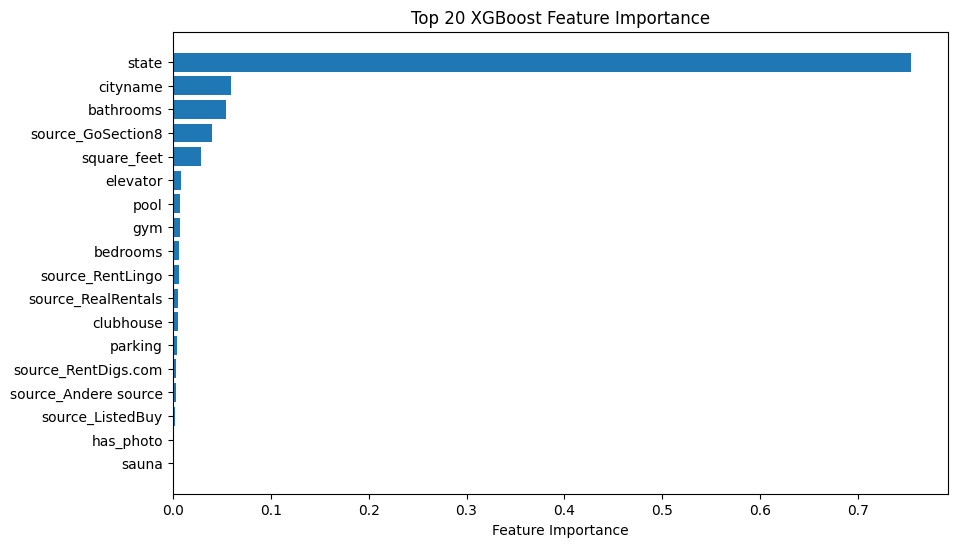

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Feature Importances
importances = xgb_final_model.feature_importances_

# Sortiere Indizes nach Wichtigkeit absteigend
indices = np.argsort(importances)[::-1]

# Nur die Top 20
top_n = 20
top_indices = indices[:top_n]
top_features = [X.columns[i] for i in top_indices]
top_importances = importances[top_indices]

# Barplot
plt.figure(figsize=(10,6))
plt.barh(top_features[::-1], top_importances[::-1])  # umgekehrt für höchste oben
plt.xlabel("Feature Importance")
plt.title("Top 20 XGBoost Feature Importance")
plt.show()



# XGBoost und kategoriale Features – Zusammenfassung

## 1. Umgang mit kategorialen Features

XGBoost kann **kategoriale Features nativ** verarbeiten, wenn `enable_categorical=True` gesetzt ist.

- **Keine One-Hot-Encoding** notwendig.  
- Kategorien werden intern als Sets behandelt.  
- Jeder Split teilt die Kategorien in zwei Mengen auf:




- Ziel: Split, der den Loss maximal reduziert.

---

## 2. Effiziente Split-Auswahl

Direktes Prüfen aller möglichen Teilmengen ist **exponentiell** (~2^(K-1) für K Kategorien).  
XGBoost löst das so:

1. Für jede Kategorie c wird die Summe der Gradienten \(G_c = \sum g_i\) und Hessians \(H_c = \sum h_i\) berechnet.  
2. Kategorien werden nach **G/H** sortiert:

$$
\frac{G_c}{H_c} \quad \text{(optimaler Leaf-Wert der Kategorie)}
$$

3. Nur die **K-1 möglichen Splits** entlang dieser Reihenfolge werden getestet:  
--> **lineare Anzahl an Splits** durchsuchen anstatt exponentiell vieler




- **Gain** für jeden Split:

$$
\text{Gain} = \frac{1}{2} \Big(
\frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L+G_R)^2}{H_L+H_R+\lambda}
\Big) - \gamma
$$

- Split mit **maximalem Gain** wird gewählt.  
--> man kann zeigen, dass der Split mit maximalem Gain durch einen Split entlang der Reihenfolge (Kategorien aufsteigend nach G/H sortiert) gefunden wird

---

## 3. Gain und Summe der quadrierten Abweichungen (SSE)

- Bei MSE-Regression:

$$
L = \frac12 (y_i - \hat y_i)^2
$$

- Gradienten und Hessians:

$$
g_i = \hat y_i - y_i \quad , \quad h_i = 1
$$
Hierbei ist $\hat y_i$ die Vorhersage von $y_i$ vor dem Aufbau des neuen Baumes. Der Gradient ist also genau das Residuum, das gefittet werden soll

- Gain reduziert sich auf:

$$
\text{Gain} \propto \text{SSE}_{parent} - (\text{SSE}_{left} + \text{SSE}_{right})
$$


- **Intuition:** Maximieren des Gains = Minimieren der Summe der SSE in den Kindern.  
- Damit wählt XGBoost **denselben Split wie klassisches Gradient Boosting** bei MSE:

$$
\text{maximize Gain} \quad \Leftrightarrow \quad \text{min } (\text{SSE}_L + \text{SSE}_R)
$$
$\text{SSE}_L = \sum_{i \in L} (w_L - r_i)^2$, where $w_L$ is the leaf value und $r_i$ is the residual which should be fitted
- Leaf-Werte:

$$
w_\text{Leaf} = - \frac{\sum g_i}{\sum h_i + \lambda} \approx \text{Mittelwert der Residuen im Fall von MSE-Regression} 
$$
($\lambda$ ist Regularisierungsparameter)

---

## 4. Parallele zu klassischem Gradient Boosting

- Klassisches Gradient Boosting auf MSE:  
  - Split-Kriterium = Minimierung der Summe der quadrierten Abweichungen in den Kinderknoten  
  - Leaf-Werte = Mittelwert der Residuen  

- XGBoost auf MSE:  
  - Split-Kriterium = Maximierung des Gains  
  - Leaf-Werte = optimaler Newton-Schritt (≈ Mittelwert der Residuen)  
  - Exponentiell viele Set-Splits bei Kategorien werden durch **G/H-Sortierung** auf linear reduziert  

- Fazit: **XGBoost ≈ Gradient Boosting bei MSE**, nur effizienter und mit zusätzlichen Regularisierungen.

---

## 5. Vorteile von XGBoost gegenüber klassischem Gradient Boosting

- Native Unterstützung für **kategoriale Features**  
- **Schnelleres Training** (Histogramm-basiert, parallele Berechnungen)  
- **Regularisierung** (L1/L2 auf Leaf-Werte)  
- **Early stopping** und minimale Gain-Schwelle (\(\gamma\)) verhindern Overfitting  
- Flexibel für **verschiedene Loss-Funktionen**, nicht nur MSE

---
